# Importations

In [1]:
from typing import List
from enum import Enum

import numpy as np
import pandas as pd

In [ ]:
def load_dataset(dataset_url: str) -> pd.DataFrame:
    current_dataset = pd.read_csv(dataset_url, header=None)
    current_dataset.columns = ['Class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', '']
    return current_dataset


load_dataset(./breast-cancer.csv)

# Dataset sur lequel nous allons travailler

In [2]:
class DataType(Enum):
    BOOLEAN = 1
    QUALITATIVE_NOMINAL = 2         # Named categories : ['FH', 'SF', 'EV']
    QUALITATIVE_ORDINAL = 3         # Categories with an implied order : ['small', 'medium', 'high']
    QUANTITATIVE_DISCRETE = 4       # Only particular numbers : [1, 2, 3, 6, 8]
    QUANTITATIVE_CONTINUOUS = 5     # Any numerical value : [1.345, 2.394, 8.345, 0.432]
    LABEL = 6                       # Label de la classification


class JobWhenMissingValue(Enum):    # Si une valeur d'un dataset est manquante
    DELETE_LINE = 1                 # - On supprime la ligne
    REPLACE_VALUE = 2               # - On remplace la valeur

class EncodingType(Enum):
    ONE_HOT_ENCODER = 1
    ORDINAL_ENCODER = 2

In [3]:
# Url à partir de la racine du dataset au format CSV
CSV_FILE_URL: str = 'breast-cancer.csv'

# Si le fichier CSV contient les noms de colonnes, mettre à True, si le fichier CSV ne contient
# que les données, et pas les titres, mettre à False
IS_CSV_FILE_CONTAINS_ROW_HEADER: bool = False

# Renommer les noms des colonnes
NAMES_ROWS_HEADER: List[str] = [
    "class",
    "age",
    "menopause",
    "tumor-size",
    "inv-nodes",
    "node-caps",
    "deg-malig",
    "breast",
    "breast-quad",
    "irradiat",
]

# Les types des données qui ont été inséré
ROWS_DATATYPES = {
    "class": {
        "datatype": DataType.BOOLEAN,
        "possible_values": [ "recurrence-events", "no-recurrence-events" ], # TRUE, FALSE
        "job_when_missing_value": {
            "type": JobWhenMissingValue.REPLACE_VALUE,
            "replace_by": False,
        }
    },
    "age": {
        "datatype": DataType.QUALITATIVE_ORDINAL,
        "possible_values": [ "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-99" ],
        "encoding": EncodingType.ORDINAL_ENCODER,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "menopause": {
        "datatype": DataType.QUALITATIVE_NOMINAL,
        "possible_values": [ "lt40", "premeno", "ge40" ],
        "encoding": EncodingType.ONE_HOT_ENCODER,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "tumor-size": {
        "datatype": DataType.QUALITATIVE_ORDINAL,
        "possible_values": [ "0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59" ],
        "encoding": EncodingType.ORDINAL_ENCODER,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "inv-nodes": {
        "datatype": DataType.QUALITATIVE_ORDINAL,
        "possible_values": [ "0-2", "3-5", "6-8", "9-11", "12-14", "15-17", "18-20", "21-23", "24-26", "27-29", "30-32", "33-35", "36-39" ],
        "encoding": EncodingType.ORDINAL_ENCODER,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "node-caps": {
        "datatype": DataType.BOOLEAN,
        "possible_values": ["yes", "no"],
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "deg-malig": {
        "datatype": DataType.QUANTITATIVE_DISCRETE,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "breast": {
        "datatype": DataType.QUALITATIVE_NOMINAL,
        "possible_values": [ "left", "right" ],
        "encoding": EncodingType.ONE_HOT_ENCODER,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "breast-quad": {
        "datatype": DataType.QUALITATIVE_NOMINAL,
        "possible_values": [ "left_up",  "left_low",  "right_up",  "right_low",  "central" ],
        "encoding": EncodingType.ONE_HOT_ENCODER,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
    "irradiat": {
        "datatype": DataType.LABEL,
        "possible_values": ["yes", "no"],
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
        }
    },
}

In [39]:

def load_dataset(dataset_url: str, is_csv_file_contains_row_header: bool, names_raw_header: List[str]) -> pd.DataFrame:

    header_value = 1 if is_csv_file_contains_row_header else None

    current_dataset = pd.read_csv(dataset_url, header=header_value)

    if header_value is None:
        current_dataset.columns = names_raw_header

    return current_dataset

current_dataset = load_dataset(CSV_FILE_URL, IS_CSV_FILE_CONTAINS_ROW_HEADER, NAMES_ROWS_HEADER)

# Pré-processing

## Nettoyage des données

Cela consiste à enlever les données manquantes ou erronées et à corriger les erreurs éventuelles.

In [5]:
def clean_dataset(dataframe: pd.DataFrame, parameters: dict) -> pd.DataFrame:
    """ Méthode qui nettoie le dataset selon les volontés définies par le client dans `parameters`
    :param dataframe: pd.DataFrame = notre dataset
    :param parameters: dict = notre dictionnaire ROWS_DATATYPES
    """
    dataframe = dataframe.replace("?", np.nan)

    for key, value in parameters.items():

        if value["job_when_missing_value"]["type"] == JobWhenMissingValue.DELETE_LINE:
            dataframe = dataframe[dataframe[key].notna()]

        if value["job_when_missing_value"]["type"] == JobWhenMissingValue.REPLACE_VALUE:
            dataframe[key] = dataframe[key].replace(np.nan, value["job_when_missing_value"]["replace_by"])


    return dataframe.reset_index()

current_dataset = load_dataset(CSV_FILE_URL, IS_CSV_FILE_CONTAINS_ROW_HEADER, NAMES_ROWS_HEADER)
clean_dataset(current_dataset, ROWS_DATATYPES)

,index,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...,...
272,281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
273,282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
274,283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
275,284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


## Normalisation des données (uniquement pour les données quantitatives)

Cela consiste à mettre toutes les données sur la même échelle, afin d'éviter que certains attributs aient un poids plus important que d'autres dans l'analyse.

In [6]:
from sklearn.preprocessing import minmax_scale

def normalize_dataset(dataframe: pd.DataFrame, parameters: dict) -> pd.DataFrame:
    """
    :param dataframe:
    :param parameters:
    :return:
    """
    for key, value in parameters.items():

        if value["datatype"] == DataType.QUANTITATIVE_DISCRETE or value["datatype"] == DataType.QUANTITATIVE_CONTINUOUS:

            dataframe[[key]] = minmax_scale(dataframe[[key]])

    return dataframe

current_dataset = load_dataset(CSV_FILE_URL, IS_CSV_FILE_CONTAINS_ROW_HEADER, NAMES_ROWS_HEADER)
normalize_dataset(current_dataset, ROWS_DATATYPES)

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,1.0,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,0.5,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,0.5,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,0.5,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,0.5,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,0.5,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,1.0,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,0.0,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,1.0,left,left_low,no


## Transformation des données

Cela consiste à appliquer des transformations mathématiques aux données afin de les mettre sous une forme qui convient mieux à l'analyse. Par exemple, il peut être utile de transformer des données catégorielles en données numériques.

In [7]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

def transform_data(dataframe: pd.DataFrame, parameters: dict) -> pd.DataFrame:
    """
    "datatype": DataType.QUALITATIVE_ORDINAL,
        "possible_values": [ "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90-99" ],
        "encoding": EncodingType.ORDINAL_ENCODER,
        "job_when_missing_value": {
            "type": JobWhenMissingValue.DELETE_LINE,
    }
    """

    for key, value in parameters.items():
        if value["datatype"] == DataType.BOOLEAN:
            remplacement = {
                value["possible_values"][0]: True,
                value["possible_values"][1]: False
            }

            dataframe[key] = dataframe[key].map(remplacement)

        if "encoding" in value and value["encoding"] == EncodingType.ORDINAL_ENCODER:
            # Création de l'objet OrdinalEncoder
            ordinal_encoder = OrdinalEncoder(categories=[value["possible_values"]])

            # Encodage des valeurs de la colonne
            dataframe[key] = ordinal_encoder.fit_transform(dataframe[[key]])

        if "encoding" in value and value["encoding"] == EncodingType.ONE_HOT_ENCODER:
            # Création de l'objet OneHotEncoder
            one_hot_encoder = OneHotEncoder(categories=[value["possible_values"]])

            # Encodage des valeurs de la colonne
            values_encoded = one_hot_encoder.fit_transform(dataframe[[key]]).toarray()

            dataframe = dataframe.drop(key, axis=1)

            dataframe_encoded = pd.DataFrame(values_encoded, columns=[f"{key}_{x}" for x in one_hot_encoder.categories_[0]])
            dataframe = dataframe.join(dataframe_encoded)



    return dataframe

current_dataset = load_dataset(CSV_FILE_URL, IS_CSV_FILE_CONTAINS_ROW_HEADER, NAMES_ROWS_HEADER)
current_dataset = clean_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = normalize_dataset(current_dataset, ROWS_DATATYPES)
transform_data(current_dataset, ROWS_DATATYPES)

,index,class,age,tumor-size,inv-nodes,node-caps,deg-malig,irradiat,menopause_lt40,menopause_premeno,menopause_ge40,breast_left,breast_right,breast-quad_left_up,breast-quad_left_low,breast-quad_right_up,breast-quad_right_low,breast-quad_central
0,0,False,2.0,6.0,0.0,False,1.0,no,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,False,3.0,4.0,0.0,False,0.5,no,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2,False,3.0,4.0,0.0,False,0.5,no,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,False,5.0,3.0,0.0,False,0.5,no,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,4,False,3.0,0.0,0.0,False,0.5,no,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,281,True,2.0,6.0,0.0,False,0.5,no,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
273,282,True,2.0,4.0,0.0,False,1.0,yes,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
274,283,True,5.0,4.0,0.0,False,0.0,no,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
275,284,True,3.0,6.0,1.0,False,1.0,no,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


# Split des données

In [8]:
from sklearn.model_selection import train_test_split

def split_datas(dataframe: pd.DataFrame, parameters: dict):

    label_column_name = None

    for key, value in parameters.items():
        if value["datatype"] == DataType.LABEL:
            label_column_name = key

    if label_column_name is None:
        raise ValueError("Cannot find the label column")

    y = dataframe[label_column_name]
    X = dataframe.drop(label_column_name, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

current_dataset = load_dataset(CSV_FILE_URL, IS_CSV_FILE_CONTAINS_ROW_HEADER, NAMES_ROWS_HEADER)
current_dataset = clean_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = normalize_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = transform_data(current_dataset, ROWS_DATATYPES)

split_datas(current_dataset, ROWS_DATATYPES)

(     index  class  age  tumor-size  inv-nodes  node-caps  deg-malig  \
 261    270   True  4.0         6.0        2.0       True        1.0   
 116    116  False  2.0         3.0        0.0      False        0.0   
 191    196  False  4.0         2.0        1.0      False        0.0   
 74      74  False  2.0         1.0        0.0      False        0.5   
 5        5  False  5.0         3.0        0.0      False        0.5   
 ..     ...    ...  ...         ...        ...        ...        ...   
 273    282   True  2.0         4.0        0.0      False        1.0   
 115    115  False  4.0         4.0        0.0      False        0.5   
 141    141  False  4.0         4.0        1.0       True        0.5   
 72      72  False  5.0         4.0        0.0      False        0.5   
 150    151  False  5.0         6.0        1.0       True        1.0   
 
      menopause_lt40  menopause_premeno  menopause_ge40  breast_left  \
 261             0.0                0.0             1.0       

# Classification

- Arbres de décision : l'algorithme de décision arbre (DecisionTreeClassifier) permet de créer un modèle de classification en utilisant une structure de décision hiérarchique basée sur les caractéristiques du jeu de données.

- Forêts aléatoires : l'algorithme de forêt aléatoire (RandomForestClassifier) est une extension de l'algorithme de décision arbre qui crée un ensemble de arbres de décision et utilise la moyenne de leurs prédictions pour améliorer la robustesse du modèle.

- Réseaux de neurones : l'algorithme de réseau de neurones (MLPClassifier) est un algorithme de classification basé sur l'apprentissage profond qui utilise une architecture de réseau de neurones pour effectuer la classification.

- SVM (Support Vector Machines) : l'algorithme SVM (SVC) est un algorithme de classification qui utilise des hyperplans de séparation pour séparer les différentes classes dans l'espace des features.

- K-mean : l'algorithme KNN (KNeighborsClassifier) est un algorithme de classification qui prédit la classe d'une observation en utilisant la classe majoritaire des K observations les plus proches de cette observation.

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def evaluate_classifiers(X_train, y_train, X_val, y_val):
    # Création d'une instance de chaque algorithme de classification
    tree_clf = DecisionTreeClassifier()
    forest_clf = RandomForestClassifier()
    neural_net_clf = MLPClassifier()
    svm_clf = SVC()
    knn_clf = KNeighborsClassifier()

    # Entraînement de chaque algorithme sur les données d'entraînement
    tree_clf.fit(X_train, y_train)
    forest_clf.fit(X_train, y_train)
    neural_net_clf.fit(X_train, y_train)
    svm_clf.fit(X_train, y_train)
    knn_clf.fit(X_train, y_train)

    # Évaluation de la performance de chaque algorithme sur les données de validation
    tree_predictions = tree_clf.predict(X_val)
    forest_predictions = forest_clf.predict(X_val)
    neural_net_predictions = neural_net_clf.predict(X_val)
    svm_predictions = svm_clf.predict(X_val)
    knn_predictions = knn_clf.predict(X_val)

    # Calcul de l'accuracy de chaque algorithme
    tree_accuracy = accuracy_score(y_val, tree_predictions)
    forest_accuracy = accuracy_score(y_val, forest_predictions)
    neural_net_accuracy = accuracy_score(y_val, neural_net_predictions)
    svm_accuracy = accuracy_score(y_val, svm_predictions)
    knn_accuracy = accuracy_score(y_val, knn_predictions)

    print(f"tree_accuracy : {tree_accuracy}")
    print(f"forest_accuracy : {forest_accuracy}")
    print(f"neural_net_accuracy : {neural_net_accuracy}")
    print(f"svm_accuracy : {svm_accuracy}")
    print(f"knn_accuracy : {knn_accuracy}")


current_dataset = load_dataset(CSV_FILE_URL, IS_CSV_FILE_CONTAINS_ROW_HEADER, NAMES_ROWS_HEADER)
current_dataset = clean_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = normalize_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = transform_data(current_dataset, ROWS_DATATYPES)

X_train, y_train, X_val, y_val, X_test, y_test = split_datas(current_dataset, ROWS_DATATYPES)
evaluate_classifiers(X_train, y_train, X_val, y_val)

tree_accuracy : 0.6964285714285714
forest_accuracy : 0.6785714285714286
neural_net_accuracy : 0.7142857142857143
svm_accuracy : 0.7142857142857143
knn_accuracy : 0.7142857142857143


In [10]:
CLASSIFIERS_CONFIG = [
    DecisionTreeClassifier(criterion="gini", splitter="best", ),
    RandomForestClassifier(n_estimators=200),
    MLPClassifier(activation="relu"),
    SVC(C=1.2),
    KNeighborsClassifier(n_neighbors=6),
]


def launch_analysis(X_train, y_train, X_val, y_val, CLASSIFIERS_CONFIG):

    results = {}

    for classifier in CLASSIFIERS_CONFIG:
        classifier.fit(X_train, y_train)
        prediction = classifier.predict(X_val)
        score = accuracy_score(y_val, prediction)

        results[f"{classifier}"] = {
            "score": score,
            "trained_classifier": classifier
        }

    return results


current_dataset = load_dataset(CSV_FILE_URL, IS_CSV_FILE_CONTAINS_ROW_HEADER, NAMES_ROWS_HEADER)
current_dataset = clean_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = normalize_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = transform_data(current_dataset, ROWS_DATATYPES)

X_train, y_train, X_val, y_val, X_test, y_test = split_datas(current_dataset, ROWS_DATATYPES)
launch_analysis(X_train, y_train, X_val, y_val, CLASSIFIERS_CONFIG)

/Users/williamdandrea/config/virtual_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'DecisionTreeClassifier()': {'score': 0.6964285714285714,
  'trained_classifier': DecisionTreeClassifier()},
 'RandomForestClassifier(n_estimators=200)': {'score': 0.7142857142857143,
  'trained_classifier': RandomForestClassifier(n_estimators=200)},
 'MLPClassifier()': {'score': 0.75, 'trained_classifier': MLPClassifier()},
 'SVC(C=1.2)': {'score': 0.7142857142857143, 'trained_classifier': SVC(C=1.2)},
 'KNeighborsClassifier(n_neighbors=6)': {'score': 0.6964285714285714,
  'trained_classifier': KNeighborsClassifier(n_neighbors=6)}}

In [11]:
def launch_test(analysis_results, X_test, y_test):

    for key, value in analysis_results.items():
        trained_classifier = value["trained_classifier"]

        print(f"{key} => {value['score']} | {accuracy_score(y_test, trained_classifier.predict(X_test))}")

current_dataset = load_dataset(CSV_FILE_URL, IS_CSV_FILE_CONTAINS_ROW_HEADER, NAMES_ROWS_HEADER)
current_dataset = clean_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = normalize_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = transform_data(current_dataset, ROWS_DATATYPES)

X_train, y_train, X_val, y_val, X_test, y_test = split_datas(current_dataset, ROWS_DATATYPES)
analysis_results = launch_analysis(X_train, y_train, X_val, y_val, CLASSIFIERS_CONFIG)

launch_test(analysis_results, X_test, y_test)

DecisionTreeClassifier() => 0.7142857142857143 | 0.7142857142857143
RandomForestClassifier(n_estimators=200) => 0.7142857142857143 | 0.7857142857142857
MLPClassifier() => 0.7321428571428571 | 0.75
SVC(C=1.2) => 0.7142857142857143 | 0.8392857142857143
KNeighborsClassifier(n_neighbors=6) => 0.6964285714285714 | 0.7857142857142857


/Users/williamdandrea/config/virtual_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Test avec plusieurs hyperparametres pour chaque algo


=>  decision_tree
====> Train scores {'gini | best | 3': 0.7878787878787878, 'entropy | random | 3': 0.7818181818181819, 'gini | random | 2': 0.7757575757575759, 'gini | best | 2': 0.7757575757575758, 'log_loss | best | 3': 0.7696969696969698, 'log_loss | best | 2': 0.7636363636363637, 'log_loss | random | 2': 0.7636363636363637, 'entropy | best | 2': 0.7575757575757576, 'entropy | best | 3': 0.7454545454545455, 'entropy | random | 2': 0.7393939393939395, 'gini | random | 3': 0.7030303030303031, 'log_loss | random | 3': 0.7030303030303029}
====> Validation scores {'accuracy': 0.7321428571428571, 'precision': 0.5454545454545454, 'recall': 0.375, 'f1': 0.4444444444444444, 'auc': 0.625}
====> Tests scores {'accuracy': 0.7321428571428571, 'precision': 0.2857142857142857}


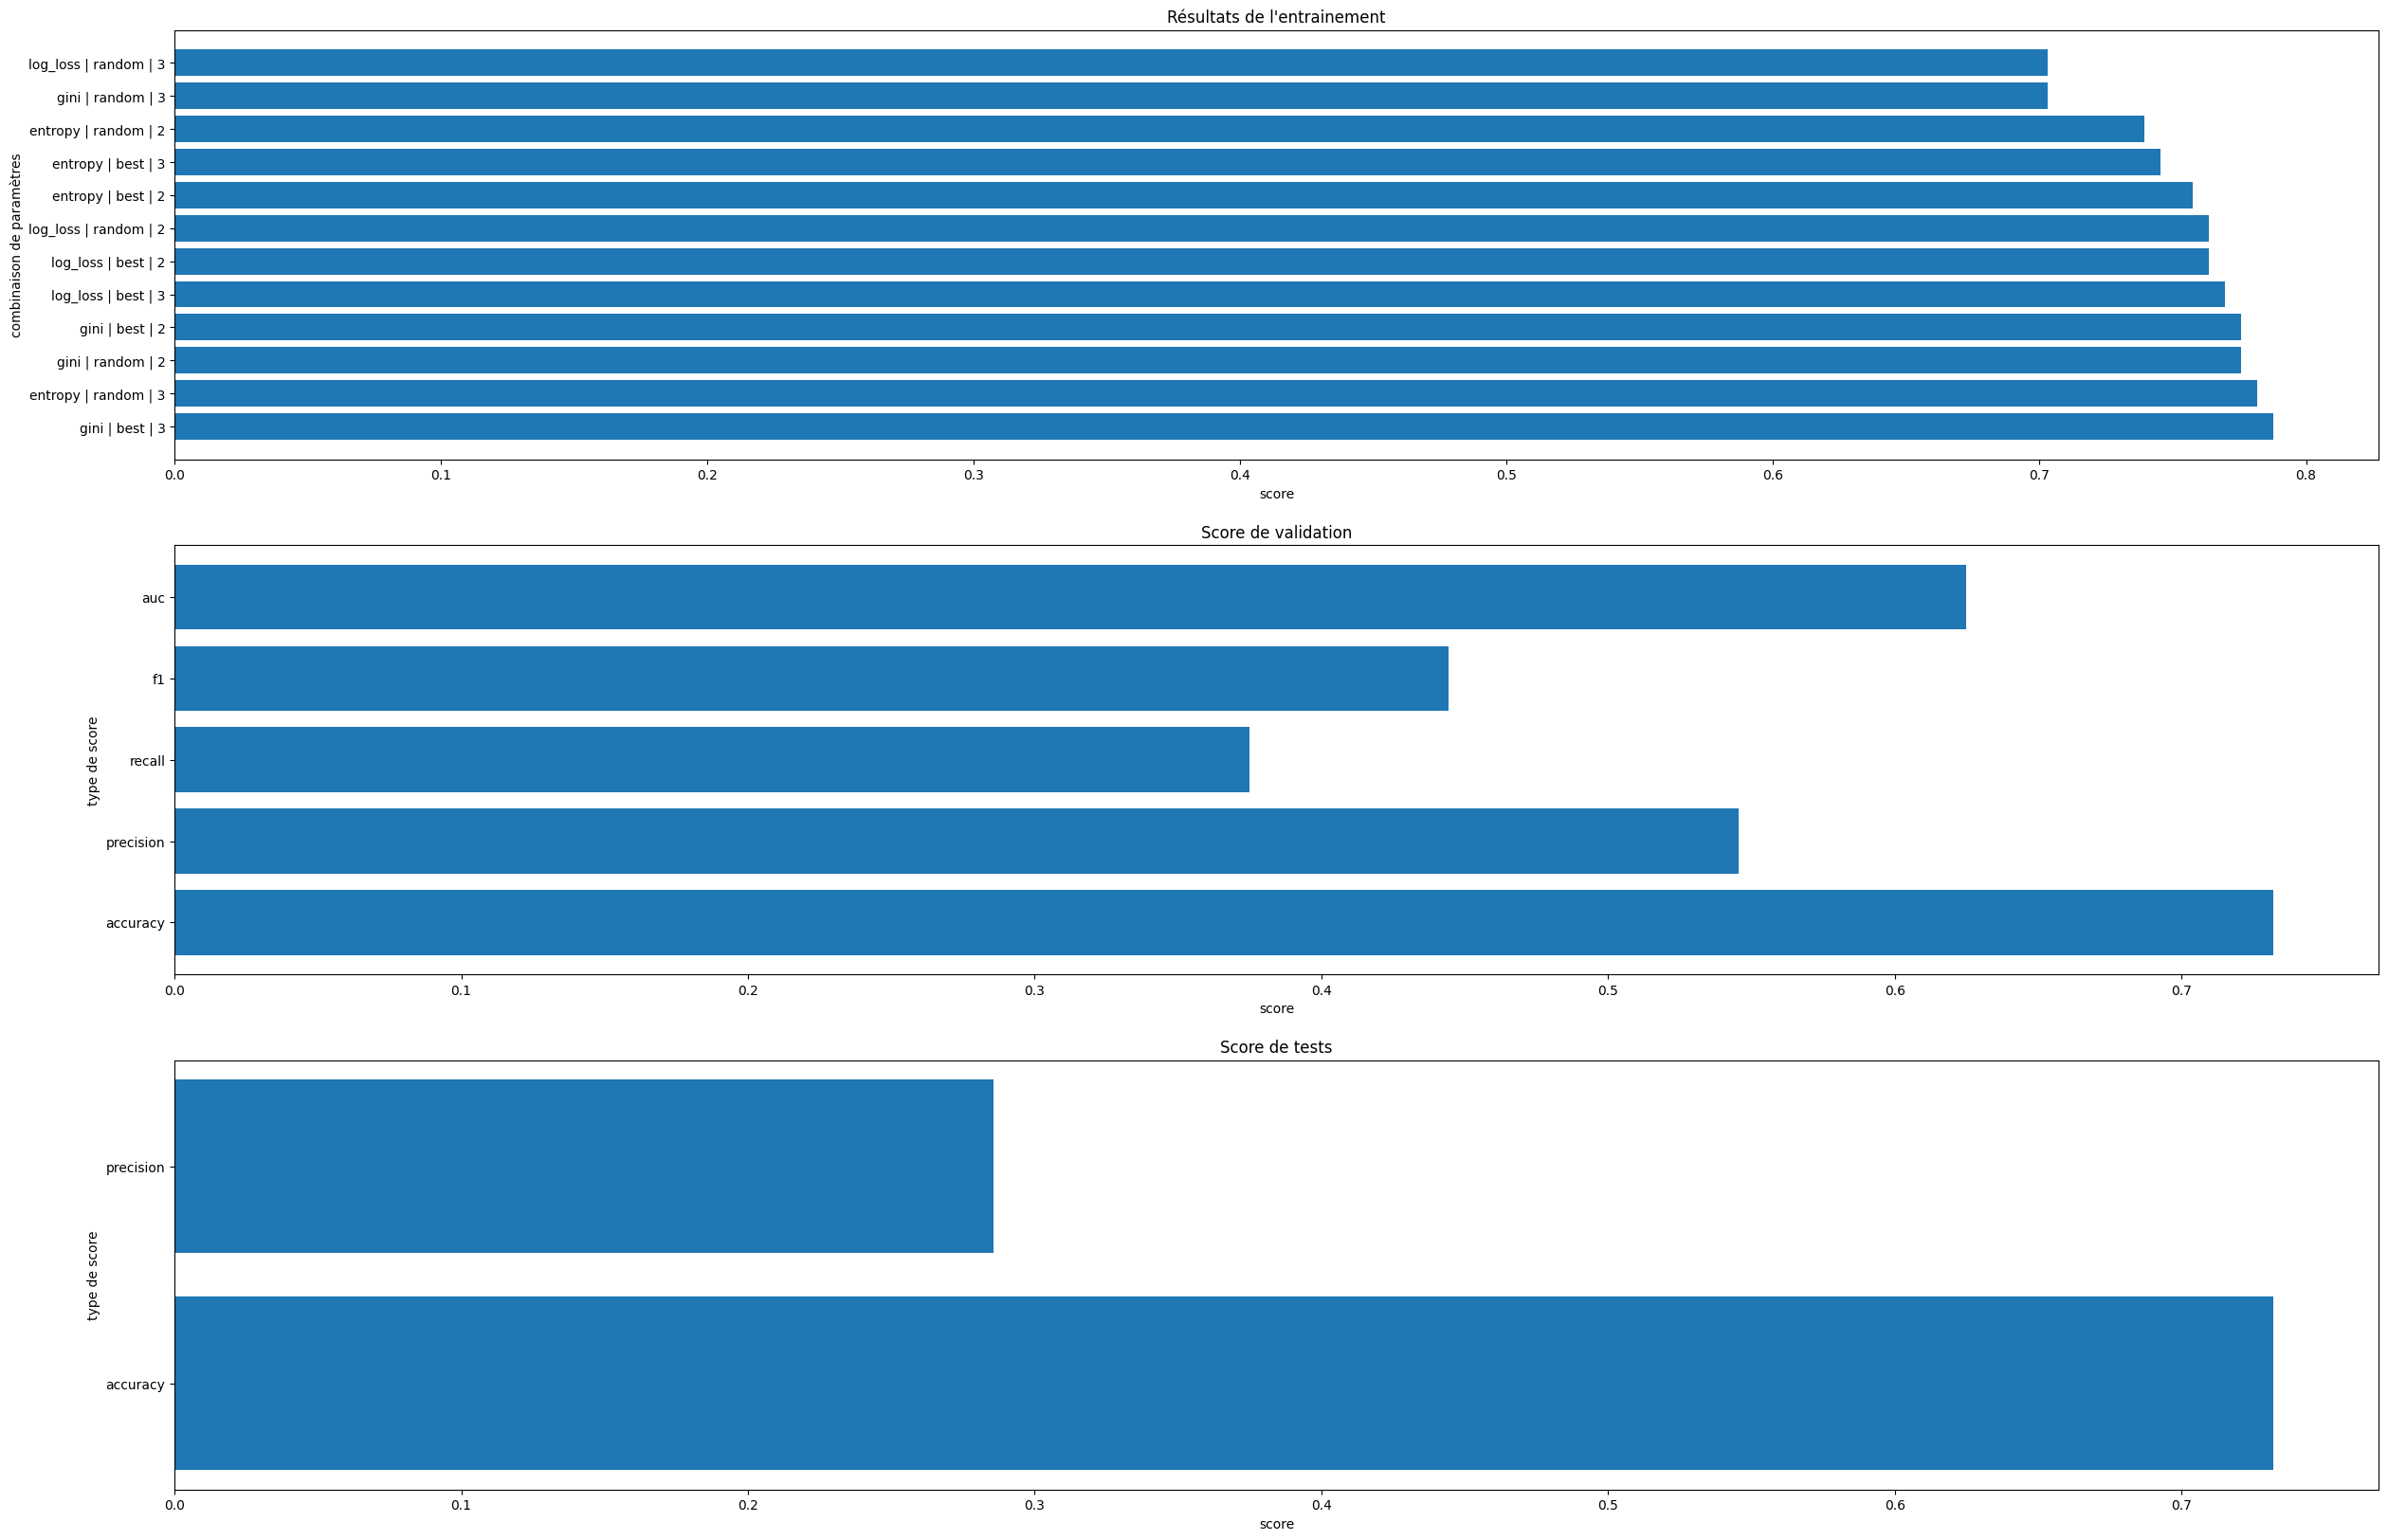

=>  random_forest
====> Train scores {'100 | log_loss': 0.8181818181818181, '100 | entropy': 0.806060606060606, '200 | entropy': 0.8, '200 | log_loss': 0.8, '100 | gini': 0.793939393939394, '200 | gini': 0.793939393939394}
====> Validation scores {'accuracy': 0.6785714285714286, 'precision': 0.25, 'recall': 0.0625, 'f1': 0.1, 'auc': 0.49375}
====> Tests scores {'accuracy': 0.7678571428571429, 'precision': 0.16666666666666666}


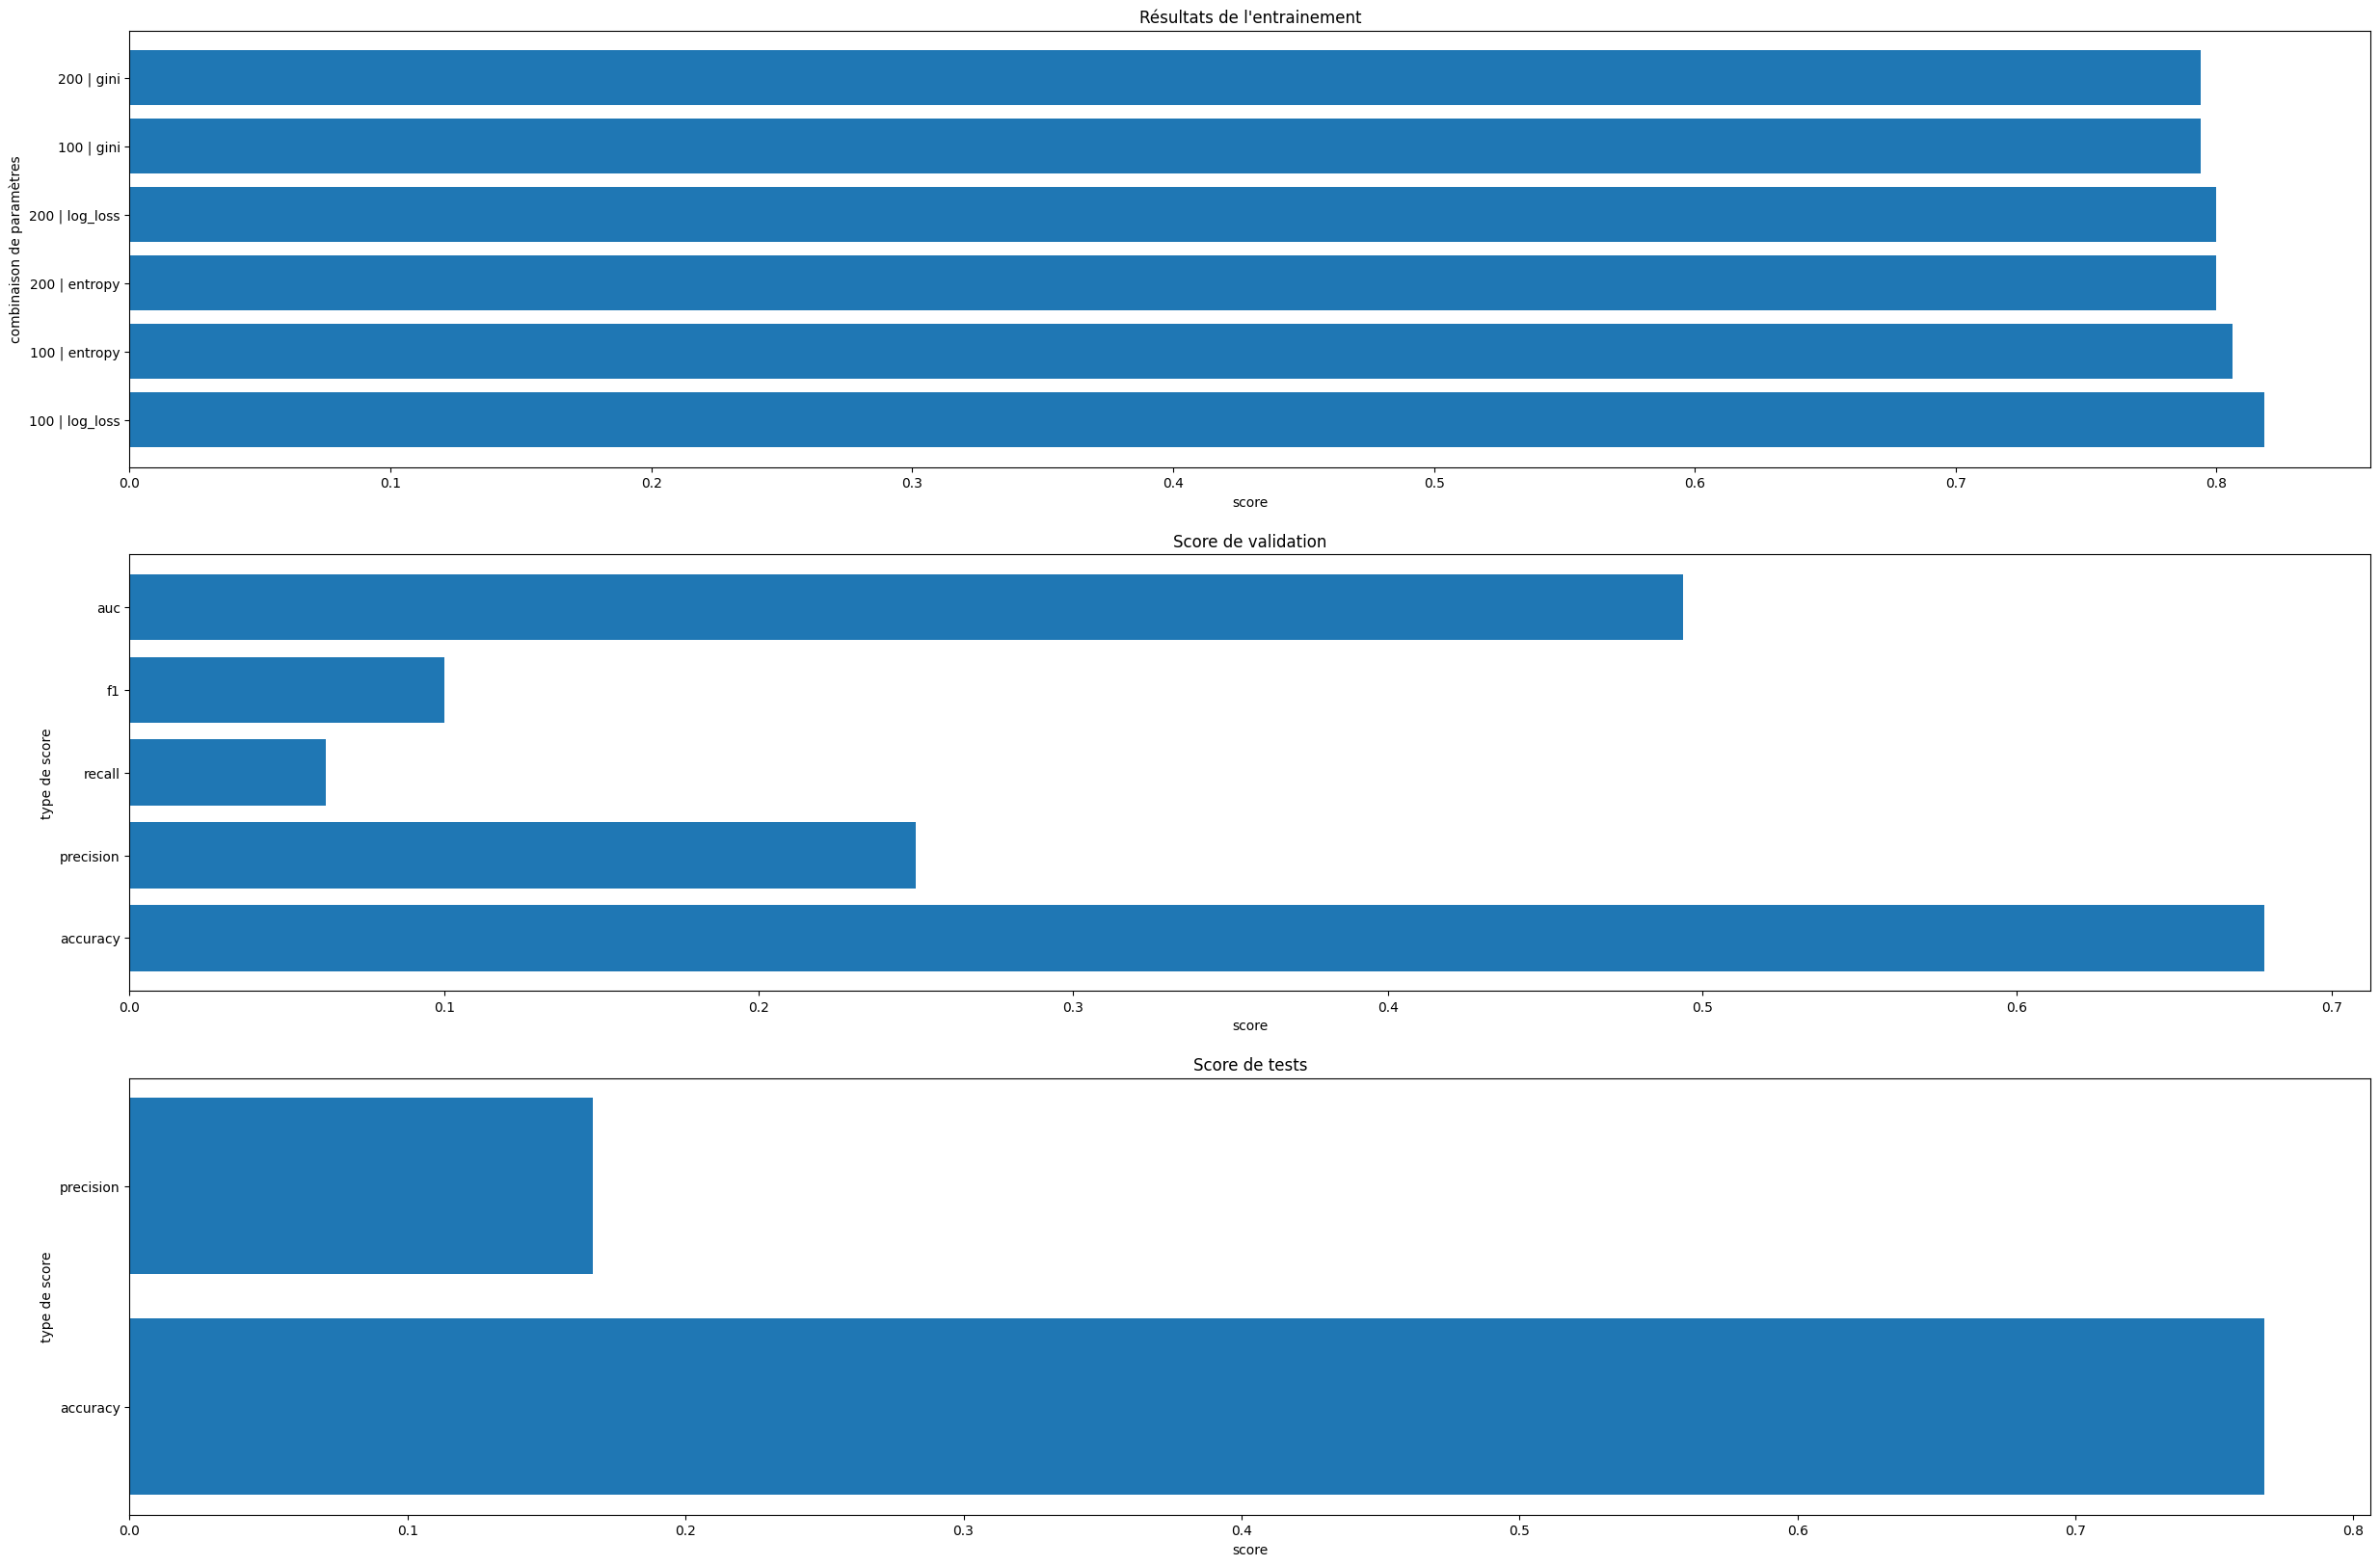

=>  MLPC
====> Train scores {'sgd | identity': 0.7878787878787878, 'sgd | logistic': 0.7757575757575758, 'sgd | tanh': 0.7757575757575758, 'lbfgs | identity': 0.7696969696969698, 'adam | identity': 0.7696969696969698, 'adam | logistic': 0.7636363636363637, 'adam | tanh': 0.7636363636363637, 'lbfgs | tanh': 0.7515151515151516, 'adam | relu': 0.7515151515151516, 'lbfgs | logistic': 0.7393939393939395, 'lbfgs | relu': 0.7393939393939393, 'sgd | relu': 0.6060606060606061}
====> Validation scores {'accuracy': 0.7321428571428571, 'precision': 0.6666666666666666, 'recall': 0.125, 'f1': 0.21052631578947367, 'auc': 0.55}
====> Tests scores {'accuracy': 0.8035714285714286, 'precision': 0.25}


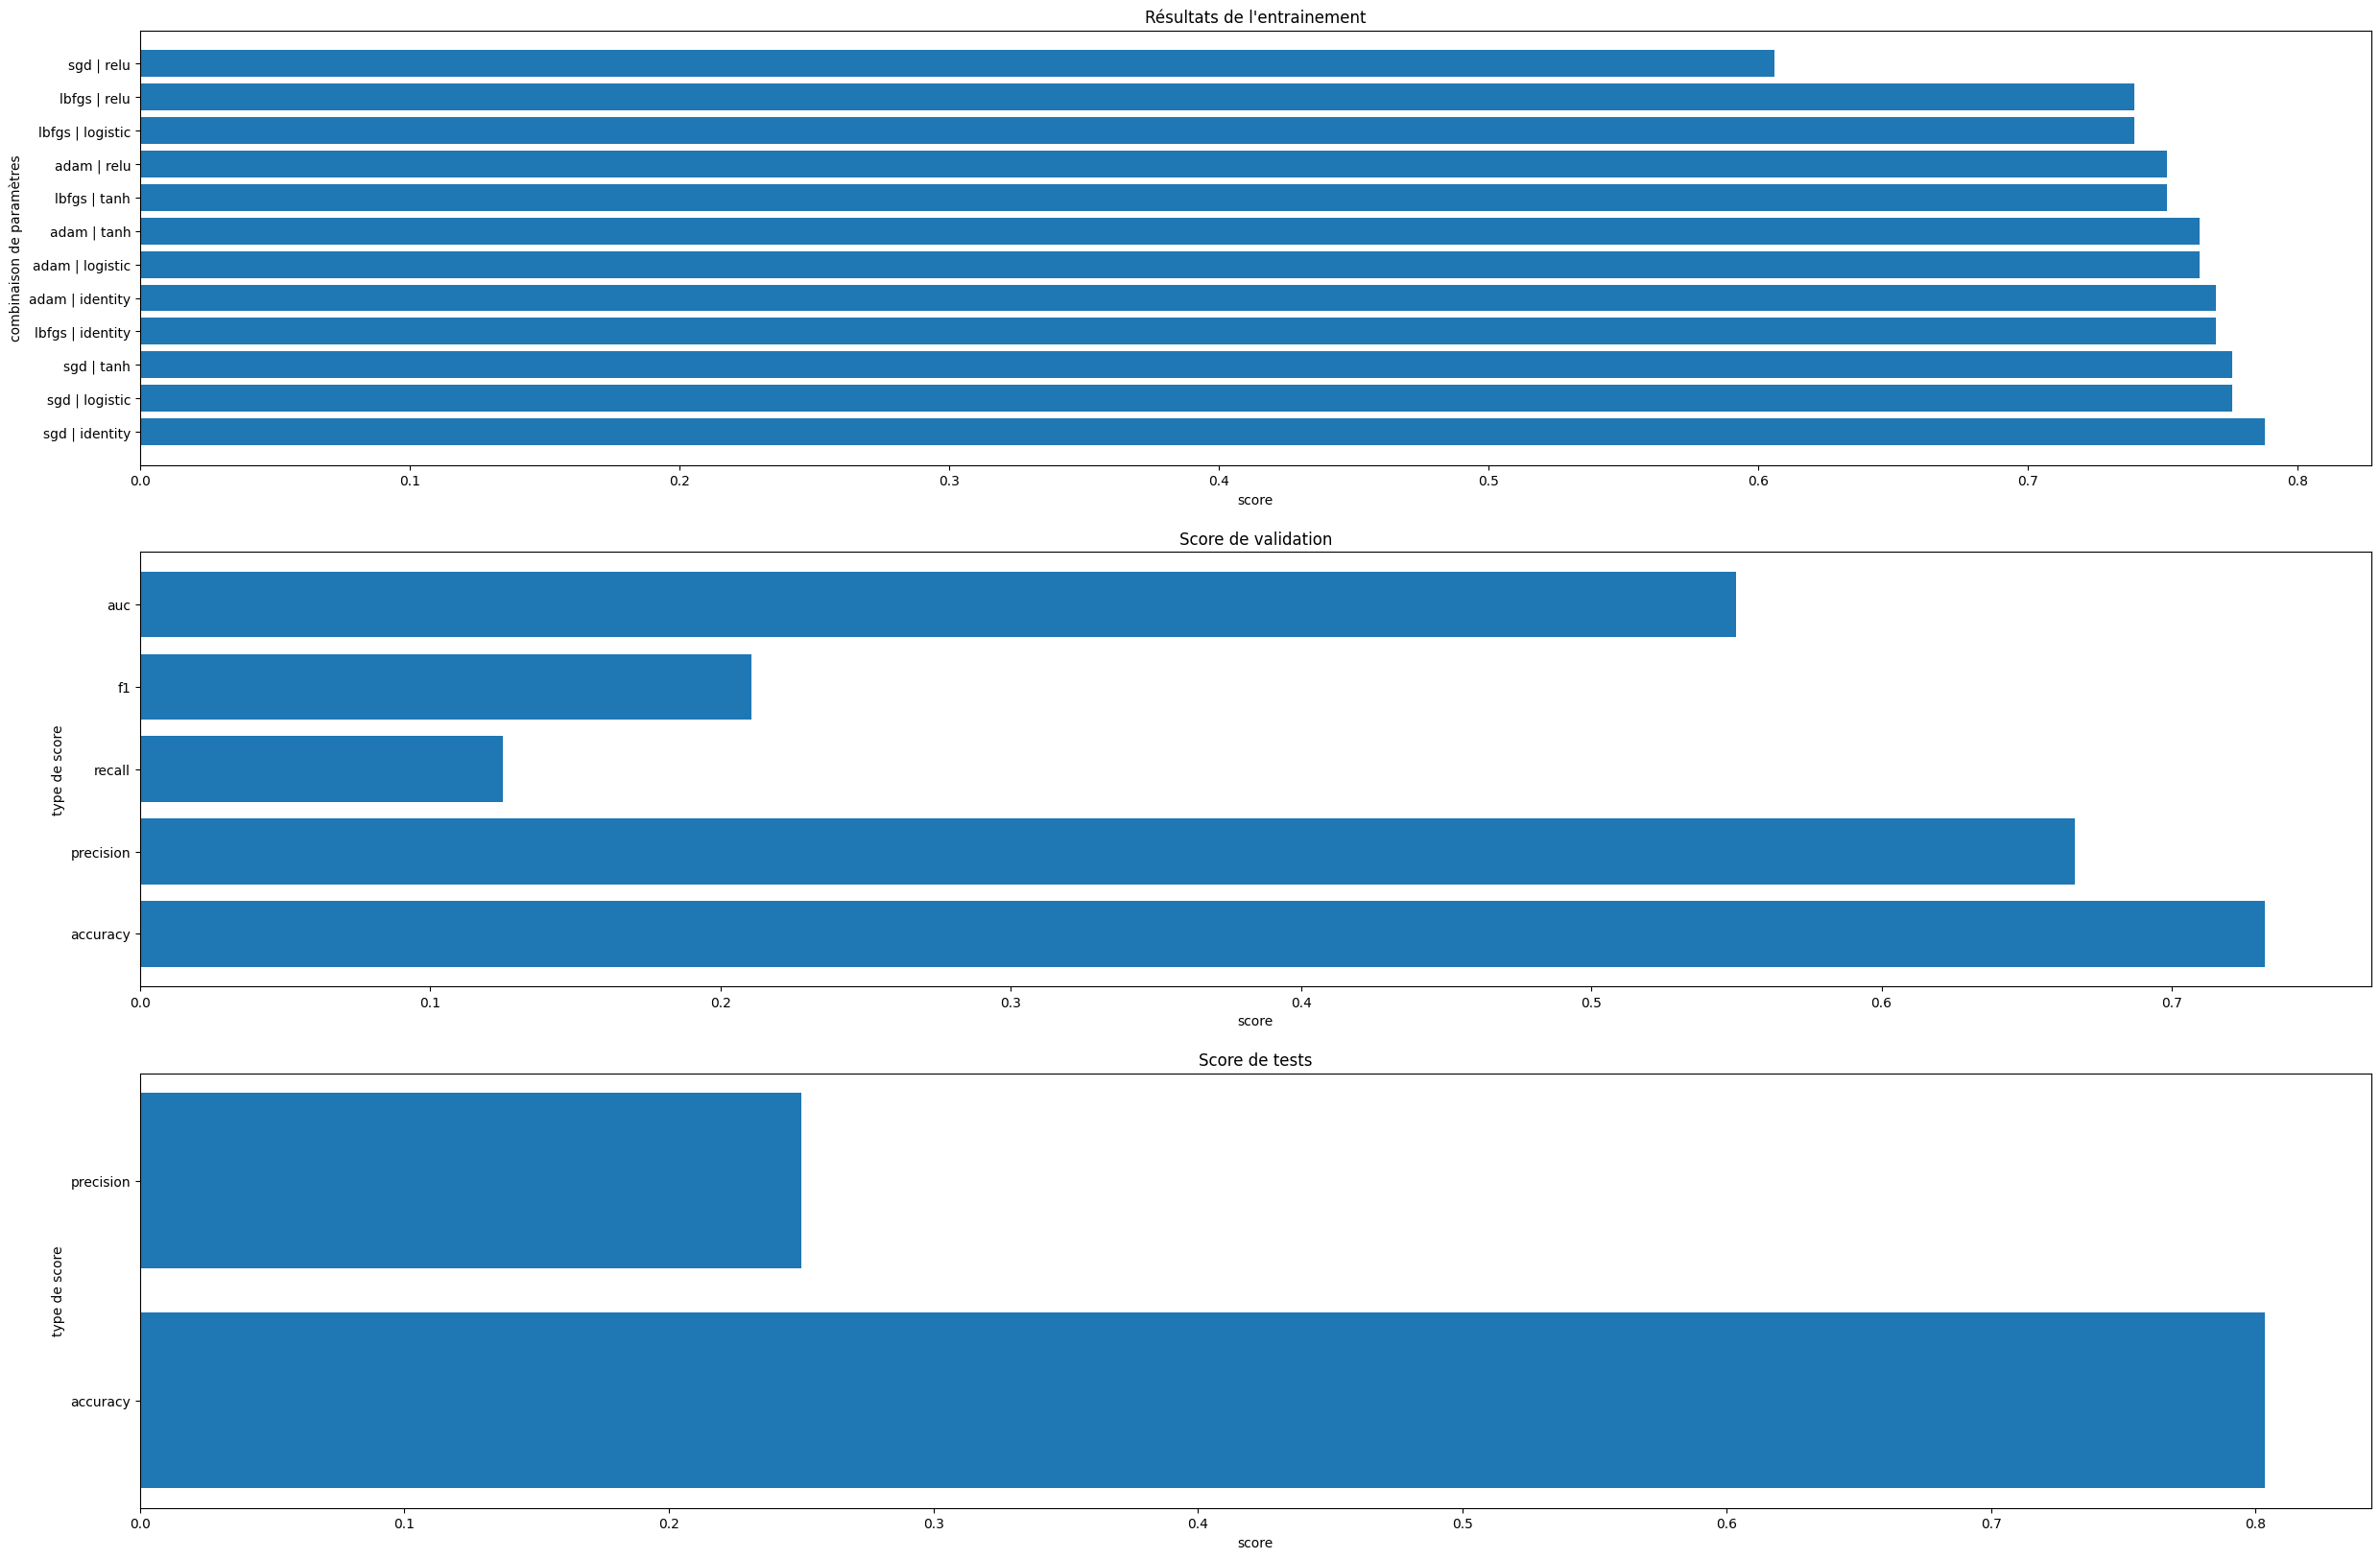

=>  SVC
====> Train scores {'1.0': 0.7757575757575758, '1.5': 0.7757575757575758, '2.0': 0.7757575757575758}
====> Validation scores {'accuracy': 0.7142857142857143, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'auc': 0.5}
====> Tests scores {'accuracy': 0.8392857142857143, 'precision': 0.0}


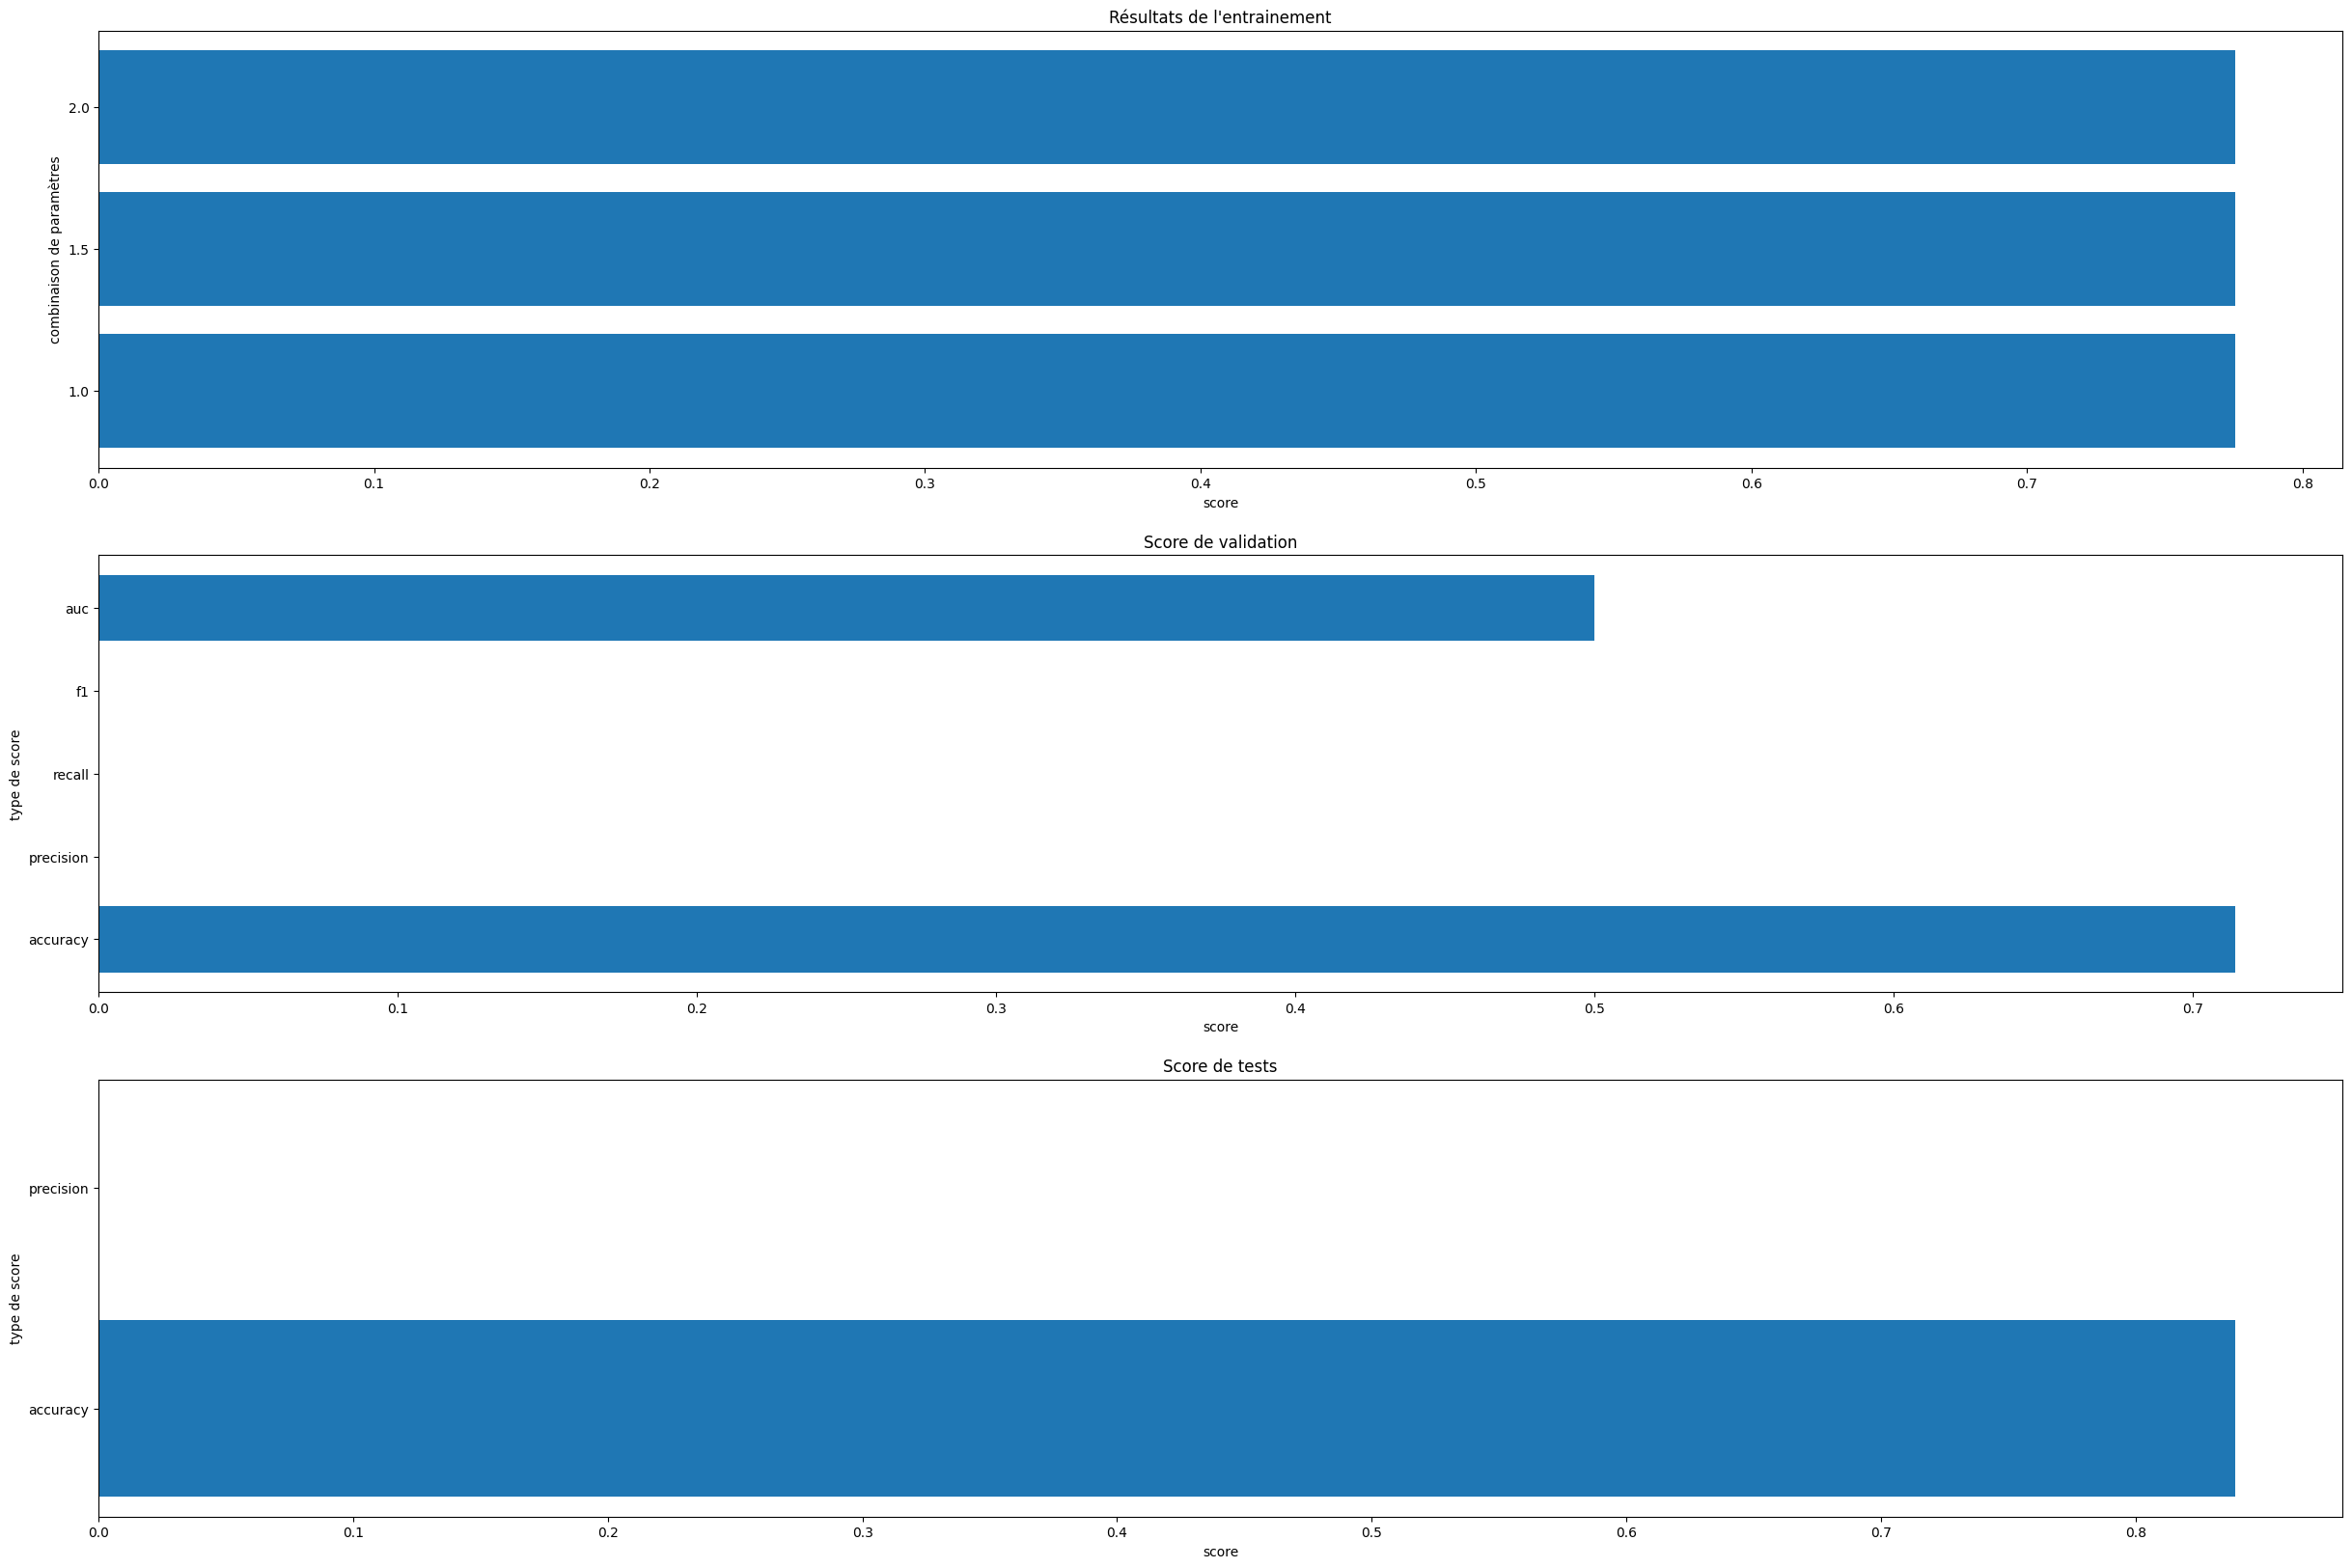

=>  k_neighbors
====> Train scores {'10.0': 0.7878787878787878, '2.0': 0.7757575757575758, '5.0': 0.7454545454545455}
====> Validation scores {'accuracy': 0.6964285714285714, 'precision': 0.4444444444444444, 'recall': 0.25, 'f1': 0.32, 'auc': 0.5625}
====> Tests scores {'accuracy': 0.7857142857142857, 'precision': 0.2857142857142857}


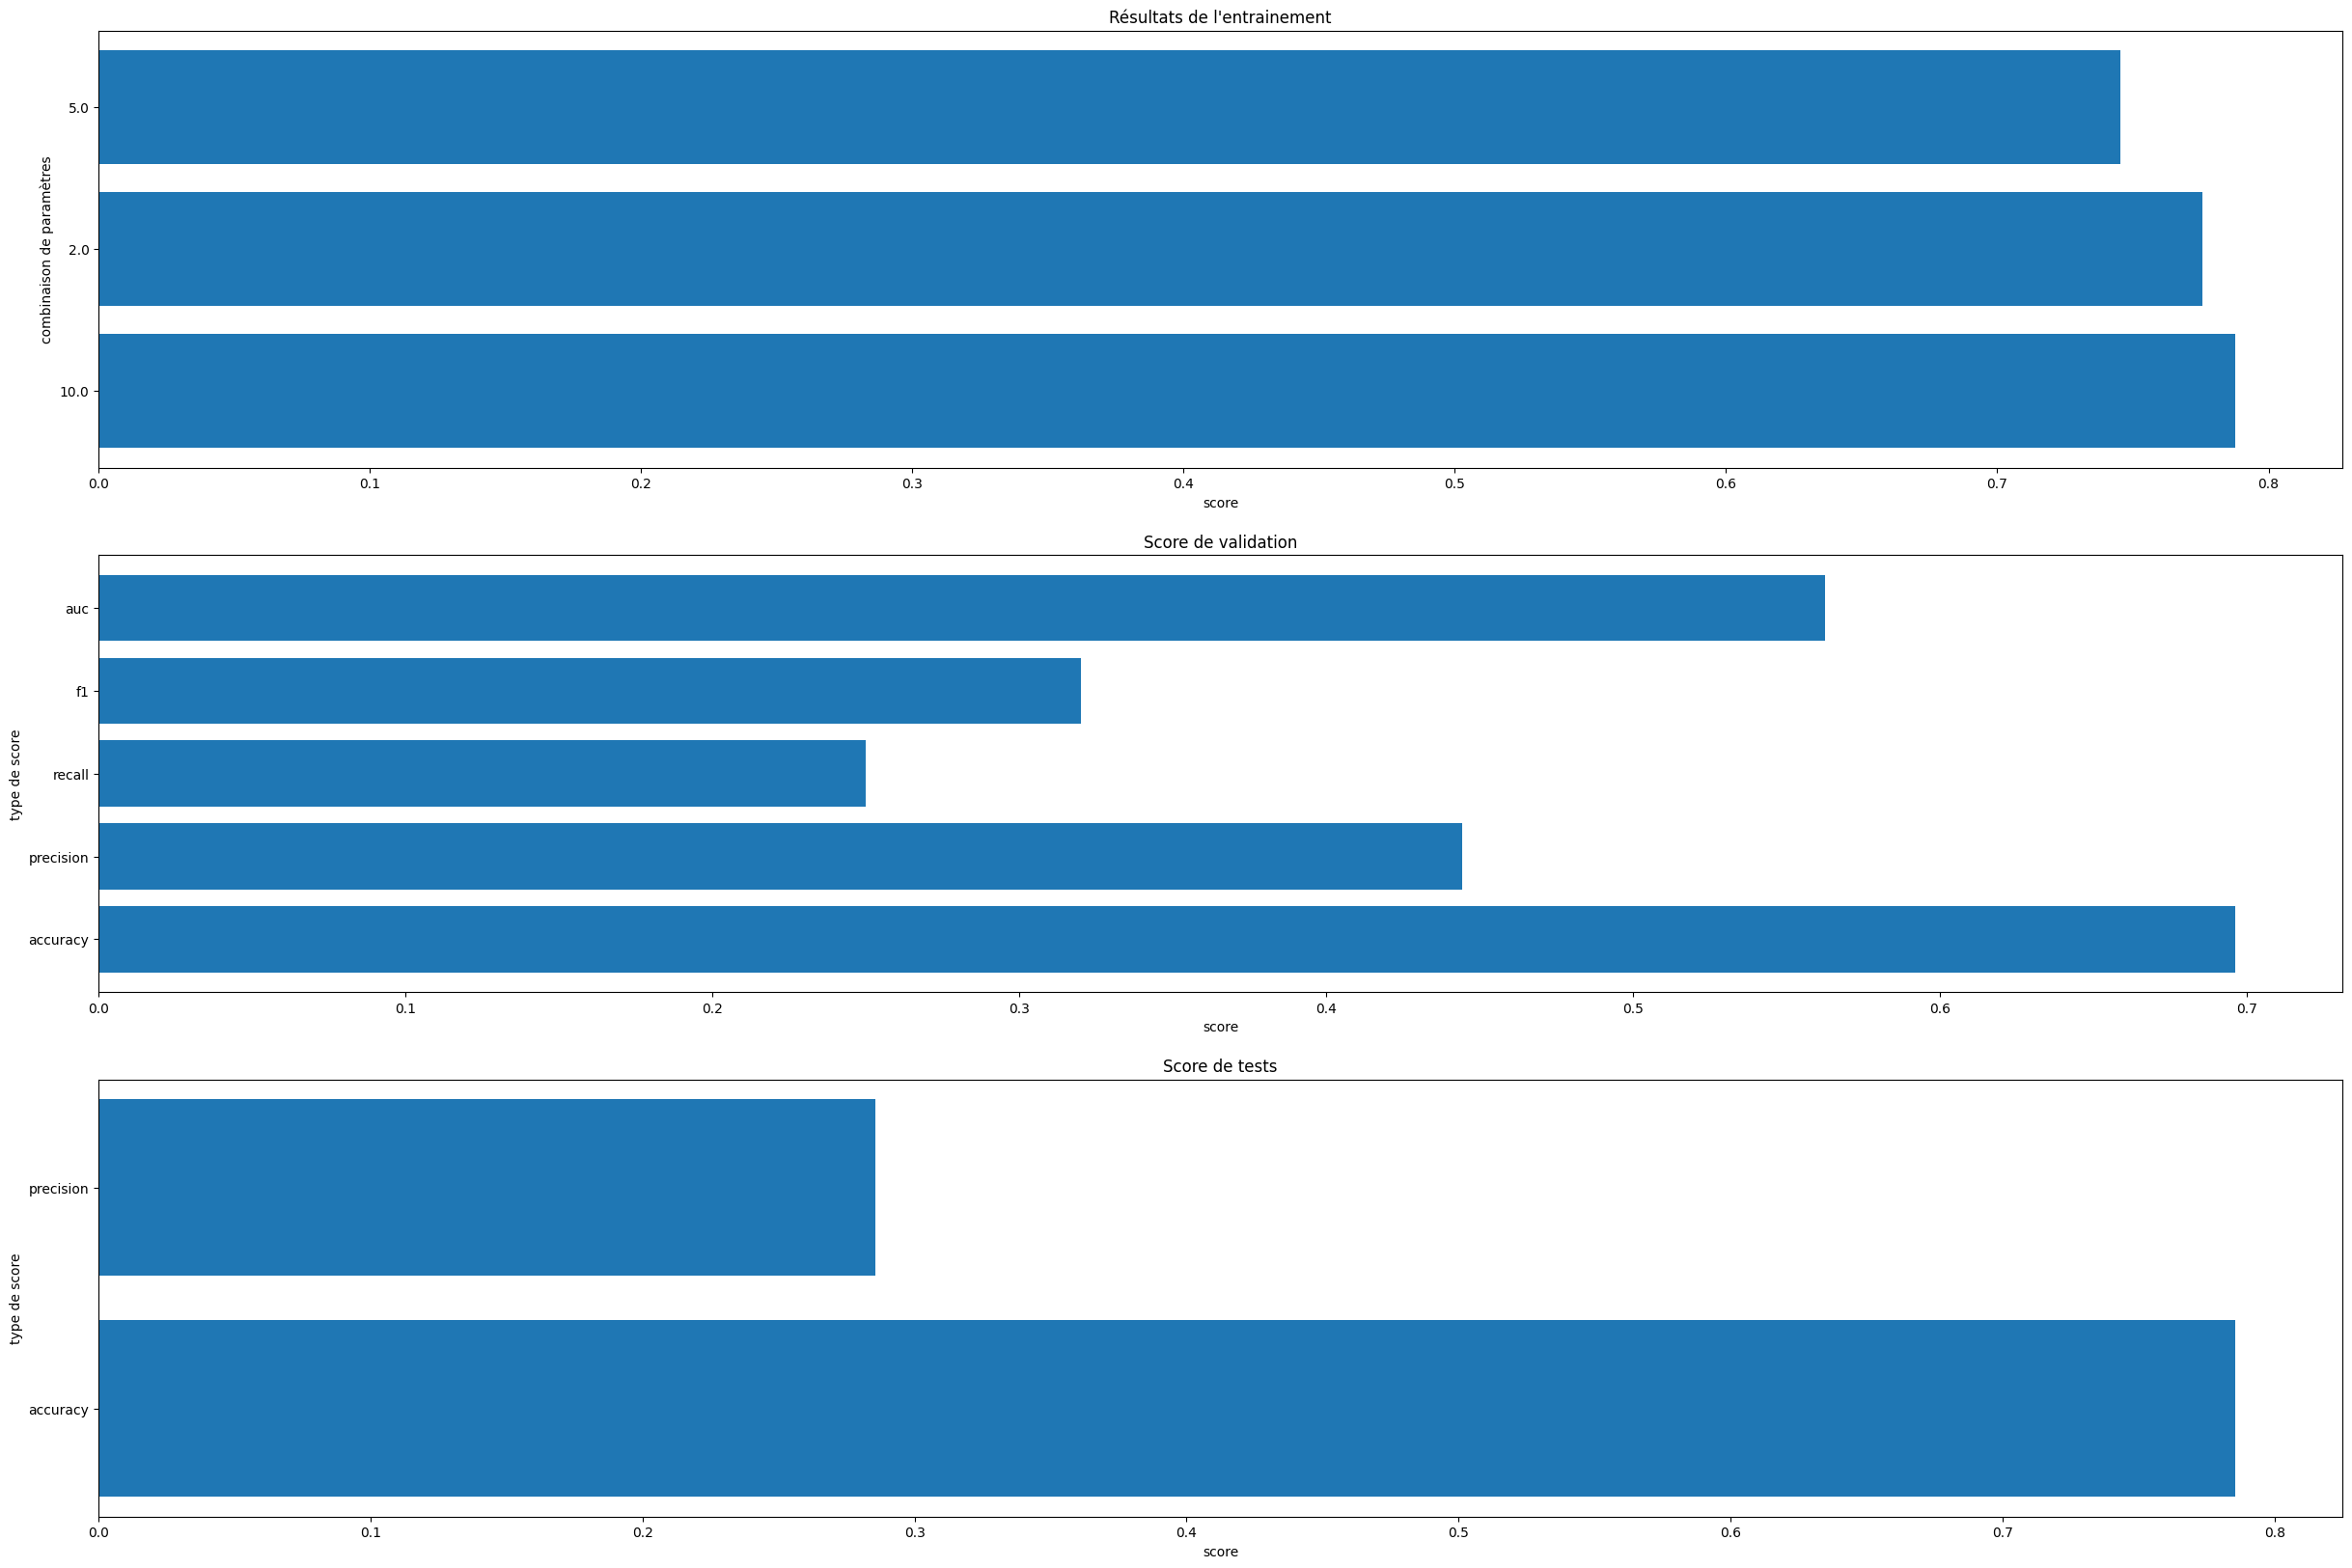

In [40]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings

warnings.filterwarnings('ignore')

CLASSIFIERS_CONFIGURATION = {
    "decision_tree": {
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "min_samples_split": [2, 3]
    },
    "random_forest": {
        "n_estimators": [100, 200],
        "criterion": ["gini", "entropy", "log_loss"],
    },
    "MLPC": {
        "solver": ['lbfgs', 'sgd', 'adam'],
        "activation" : ['identity', 'logistic', 'tanh', 'relu']
    },
    "SVC": {
        "C": [1.0, 1.5, 2.0]
    },
    "k_neighbors": {
        "n_neighbors": [2, 5, 10]
    }
}

COMPARAISONS_SCORES = {
    "validation": ["accuracy", "precision", "recall", "f1", "auc"],
    "test": ["accuracy", "precision"]
}

def generate_scores(scores_to_do: List[str], y, prediction):
    scores = {}
    y_intern = y.to_numpy()
    y_intern = np.array(np.where(y_intern == 'no', 0, 1), dtype=int)
    prediction = np.array(np.where(prediction == 'no', 0, 1), dtype=int)
    for name_score in scores_to_do:
        if name_score == "accuracy":
            scores["accuracy"] = accuracy_score(y_intern, prediction)
        if name_score == "precision":
            scores["precision"] = precision_score(y_intern, prediction)
        if name_score == "recall":
            scores["recall"] = recall_score(y_intern, prediction)
        if name_score == "f1":
            scores["f1"] = f1_score(y_intern, prediction)
        if name_score == "auc":
            scores["auc"] = roc_auc_score(y_intern, prediction)
    return scores

def plot_results(grid_search: GridSearchCV, name_cls, optimizations_values, comparaison_config, X_train, y_train, X_val, y_val, X_test, y_test):

    print("=> ", name_cls)

    # 1. Affichage des résultats sur le set de train
    results = grid_search.cv_results_

    results_dataframe = []
    columns_name = []
    for param, possible_values in optimizations_values.items():
        results_dataframe.append(results[f'param_{param}'].data)
        columns_name.append(f"{param}")
    results_dataframe.append(results['mean_test_score'])
    columns_name.append("mean_test_score")

    results_dataframe = pd.DataFrame(results_dataframe).T
    results_dataframe = results_dataframe.reset_index(drop=True)
    results_dataframe.columns = columns_name
    results_dataframe = results_dataframe.sort_values(by=['mean_test_score'], ascending=False)

    columns_name.remove("mean_test_score")
    # Créez une colonne qui concatène les valeurs de `label_col`
    results_dataframe['combinaison_hyperparameters'] = results_dataframe[columns_name].apply(lambda x: " | ".join(map(str, x)), axis=1)

    fig, ax = plt.subplots(3, 1, figsize=(30, 20))
    ax[0].barh(results_dataframe["combinaison_hyperparameters"], results_dataframe["mean_test_score"], label=name_cls)
    ax[0].set(xlabel='score', ylabel='combinaison de paramètres')
    ax[0].set_title("Résultats de l'entrainement")
    print("====> Train scores", pd.concat([results_dataframe["combinaison_hyperparameters"], results_dataframe["mean_test_score"]], axis=1).set_index('combinaison_hyperparameters')['mean_test_score'].to_dict())

    # 2. Affichage des résultats sur le set de validation
    validation_prediction = grid_search.predict(X_val)
    validations_scores = generate_scores(comparaison_config["validation"], y_val, validation_prediction)
    ax[1].barh(list(validations_scores.keys()), list(validations_scores.values()), label="Validation scores with the best combinaison")
    ax[1].set(xlabel='score', ylabel='type de score')
    ax[1].set_title('Score de validation')
    print("====> Validation scores", validations_scores)


    # 3. Affichage des résultats sur le set de test
    test_prediction = grid_search.predict(X_test)
    test_scores = generate_scores(comparaison_config["test"], y_test, test_prediction)
    ax[2].barh(list(test_scores.keys()), list(test_scores.values()), label="Validation scores with the best combinaison")
    ax[2].set(xlabel='score', ylabel='type de score')
    ax[2].set_title('Score de tests')
    print("====> Tests scores", test_scores)

    plt.show()



def launch_analysis_complete(X_train, y_train, X_val, y_val, X_test, y_test, configuration, comparaison_config):

    for name_cls, optimizations_values in configuration.items():

        clf = None

        if name_cls == "decision_tree":
            clf = DecisionTreeClassifier()

        if name_cls == "random_forest":
            clf = RandomForestClassifier()

        if name_cls == "MLPC":
            clf = MLPClassifier()

        if name_cls == "SVC":
            clf = SVC()

        if name_cls == "k_neighbors":
            clf = KNeighborsClassifier()


        # Initialisez la recherche de grille
        grid_search = GridSearchCV(estimator=clf, param_grid=optimizations_values, cv=5)

        # Entraînez votre modèle en utilisant la recherche de grille
        grid_search.fit(X_train, y_train)

        plot_results(grid_search, name_cls, optimizations_values, comparaison_config, X_train, y_train, X_val, y_val, X_test, y_test)

current_dataset = load_dataset(CSV_FILE_URL, IS_CSV_FILE_CONTAINS_ROW_HEADER, NAMES_ROWS_HEADER)
current_dataset = clean_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = normalize_dataset(current_dataset, ROWS_DATATYPES)
current_dataset = transform_data(current_dataset, ROWS_DATATYPES)

X_train, y_train, X_val, y_val, X_test, y_test = split_datas(current_dataset, ROWS_DATATYPES)
launch_analysis_complete(X_train, y_train, X_val, y_val, X_test, y_test, CLASSIFIERS_CONFIGURATION, COMPARAISONS_SCORES)